# Analiza danych medycznych – przeżywalność raka prostaty

## 1. Import bibliotek

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline
plt.style.use('seaborn-v0_8')


## 2. Import danych

In [152]:
df = pd.read_csv('CancerProstateSurvival.csv')
df.head()

,times,patient.vital_status,patient.gender,patient.race,patient.ethnicity,patient.days_to_birth,patient.drugs.drug.therapy_types.therapy_type,patient.stage_event.pathologic_stage,patient.stage_event.tnm_categories.pathologic_categories.pathologic_t,patient.stage_event.tnm_categories.pathologic_categories.pathologic_m
0,621,0,male,NaN,NaN,-18658.0,NaN,NaN,t2b,NaN
1,1332,0,male,NaN,NaN,-20958.0,NaN,NaN,t3a,NaN
2,995,0,male,NaN,NaN,-17365.0,hormone therapy,NaN,t4,NaN
3,671,0,male,NaN,NaN,-19065.0,NaN,NaN,t2b,NaN
4,1033,0,male,NaN,NaN,-25904.0,NaN,NaN,t3b,NaN


In [153]:
print('Liczba rekordów:', len(df))
df.info()

Liczba rekordów: 499
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   times                                                                  499 non-null    int64  
 1   patient.vital_status                                                   499 non-null    int64  
 2   patient.gender                                                         499 non-null    object 
 3   patient.race                                                           156 non-null    object 
 4   patient.ethnicity                                                      152 non-null    object 
 5   patient.days_to_birth                                                  488 non-null    float64
 6   patient.drugs.drug.therapy_types.therapy_type                        

## 3. Wstępne przetwarzanie danych

In [154]:
df = df.replace('NA', np.nan)

missing_counts = df.isna().sum().sort_values(ascending=False)
missing_counts

patient.stage_event.pathologic_stage                                     499
patient.stage_event.tnm_categories.pathologic_categories.pathologic_m    499
patient.drugs.drug.therapy_types.therapy_type                            426
patient.ethnicity                                                        347
patient.race                                                             343
patient.days_to_birth                                                     11
patient.stage_event.tnm_categories.pathologic_categories.pathologic_t      7
times                                                                      0
patient.vital_status                                                       0
patient.gender                                                             0
dtype: int64

In [155]:
if 'patient.vital_status' in df.columns:
    df['patient.vital_status'] = pd.to_numeric(df['patient.vital_status'], errors='coerce')

if 'patient.days_to_birth' in df.columns:
    df['patient.age_years'] = (-pd.to_numeric(df['patient.days_to_birth'], errors='coerce')) / 365.25

num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols]

for c in num_cols:
    median_val = df[c].median()
    df[c] = df[c].fillna(median_val)

for c in cat_cols:
    df[c] = df[c].fillna('Unknown')

for c in cat_cols:
    df[c] = df[c].astype('category')

(df.isna().sum() == 0).all()

c:\Programs\Python\3.11\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Programs\Python\3.11\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


np.False_

## 4. Analiza statystyczna


In [156]:
num_stats = df.select_dtypes(include=['number']).agg(['mean', 'median', 'std']).T
num_stats

c:\Programs\Python\3.11\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Programs\Python\3.11\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,mean,median,std
times,709.837675,512.000000,701.255074
patient.vital_status,0.016032,0.000000,0.125725
patient.days_to_birth,-22478.933868,-22614.000000,2451.632184
patient.stage_event.pathologic_stage,NaN,NaN,NaN
patient.stage_event.tnm_categories.pathologic_categories.pathologic_m,NaN,NaN,NaN
patient.age_years,61.543967,61.913758,6.712203


In [157]:
if 'patient.age_years' in df.columns:
    df['patient.age_years'].describe()

## 5. Wizualizacja danych

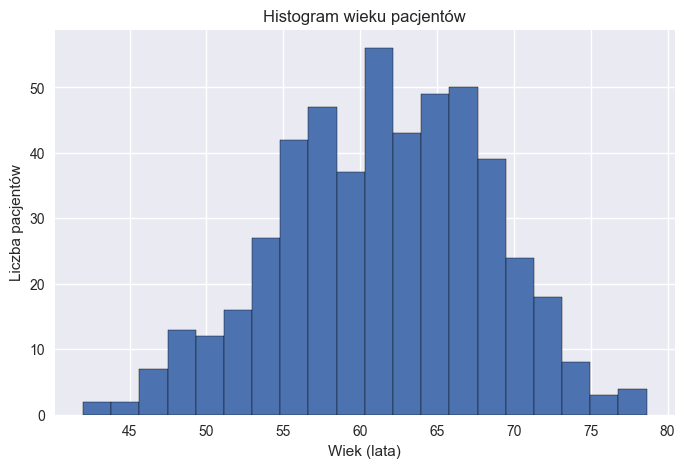

In [158]:
plt.figure(figsize=(8, 5))
plt.hist(df['patient.age_years'], bins=20, edgecolor='black')
plt.title('Histogram wieku pacjentów')
plt.xlabel('Wiek (lata)')
plt.ylabel('Liczba pacjentów')
plt.show()

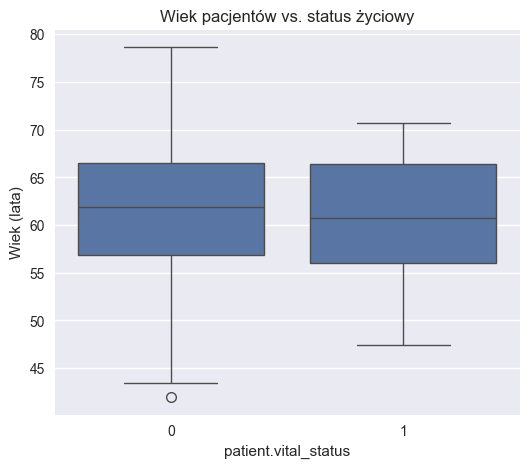

In [159]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=df, x='patient.vital_status', y='patient.age_years')
plt.title('Wiek pacjentów vs. status życiowy')
plt.xlabel('patient.vital_status')
plt.ylabel('Wiek (lata)')
plt.show()

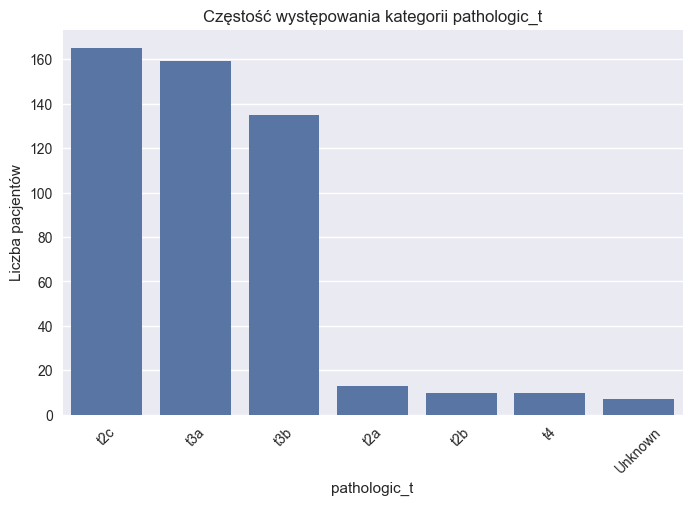

In [160]:
col_t = 'patient.stage_event.tnm_categories.pathologic_categories.pathologic_t'
plt.figure(figsize=(8, 5))
order = df[col_t].value_counts().index
sns.countplot(data=df, x=col_t, order=order)
plt.title('Częstość występowania kategorii pathologic_t')
plt.xlabel('pathologic_t')
plt.ylabel('Liczba pacjentów')
plt.xticks(rotation=45)
plt.show()

## 6. Przygotowanie do modelowania

In [161]:
target = 'patient.vital_status'

X = df.drop(columns=[target])
y = df[target].astype(int)

cat_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
num_features = X.select_dtypes(include=['number']).columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, cat_features),
        ('num', numerical_transformer, num_features)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((399, 10), (100, 10))

## 7. Model predykcyjny

In [162]:
if 'X_train' not in globals() or 'preprocess' not in globals():
    target = 'patient.vital_status'
    X = df.drop(columns=[target])
    y = df[target].astype(int)

    cat_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    num_features = X.select_dtypes(include=['number']).columns.tolist()

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])

    preprocess = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, cat_features),
            ('num', numerical_transformer, num_features)
        ]
    )

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', round(acc, 4))
print('Confusion matrix:', cm)

Accuracy: 0.98
Confusion matrix: [[98  0]
 [ 2  0]]


c:\Programs\Python\3.11\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['patient.stage_event.pathologic_stage'
 'patient.stage_event.tnm_categories.pathologic_categories.pathologic_m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Programs\Python\3.11\Lib\site-packages\sklearn\impute\_base.py:635: UserWarning: Skipping features without any observed values: ['patient.stage_event.pathologic_stage'
 'patient.stage_event.tnm_categories.pathologic_categories.pathologic_m']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
